# Importing some libraries

In [3]:
import sys
sys.path.append("../")
import os
import math
import librosa
import numpy as np
import pandas as pd
import soundfile as sf
from zipfile import ZipFile
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt
%matplotlib inline

# Managing Dataset

The dataset can be downloaded from this [link](https://bhichallenge.med.auth.gr/sites/default/files/ICBHI_final_database/ICBHI_final_database.zip)

In [ ]:
root = 'ICBHI_final_database/'

In [3]:
with ZipFile('ICBHI_final_database.zip', 'r') as zipObj:
    # Extract all the contents of zip file in current directory
    zipObj.extractall(root)
os.remove('ICBHI_final_database.zip')

In [12]:
filenames = [s.split('.')[0] for s in os.listdir(path = root) if '.txt' in s]
# Just patient info
filenames = filenames[:920]

In [13]:
def Extract_Annotation_Data(file_name, root):
    tokens = file_name.split('_')
    recording_info = pd.DataFrame(data = [tokens], columns = ['Patient number', 'Recording index', 'Chest location','Acquisition mode','Recording equipment'])
    recording_annotations = pd.read_csv(os.path.join(root, file_name + '.txt'), names = ['Start', 'End', 'Crackles', 'Wheezes'], delimiter= '\t')
    return (recording_info, recording_annotations)

In [14]:
i_list = []
rec_annotations = []
rec_annotations_dict = {}
for s in filenames:
    (i,a) = Extract_Annotation_Data(s, root)
    i_list.append(i)
    rec_annotations.append(a)
    rec_annotations_dict[s] = a
recording_info = pd.concat(i_list, axis = 0)
recording_info.head()

,Patient number,Recording index,Chest location,Acquisition mode,Recording equipment
0,101,1b1,Al,sc,Meditron
0,101,1b1,Pr,sc,Meditron
0,102,1b1,Ar,sc,Meditron
0,103,2b2,Ar,mc,LittC2SE
0,104,1b1,Al,sc,Litt3200


In [15]:
no_label_list = []
crack_list = []
wheeze_list = []
both_sym_list = []
filename_list = []
for f in filenames:
    d = rec_annotations_dict[f]
    no_labels = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 0)].index)
    n_crackles = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 0)].index)
    n_wheezes = len(d[(d['Crackles'] == 0) & (d['Wheezes'] == 1)].index)
    both_sym = len(d[(d['Crackles'] == 1) & (d['Wheezes'] == 1)].index)
    no_label_list.append(no_labels)
    crack_list.append(n_crackles)
    wheeze_list.append(n_wheezes)
    both_sym_list.append(both_sym)
    filename_list.append(f)

In [16]:
file_label_df = pd.DataFrame(data = {'filename':filename_list, 'no label':no_label_list, 'crackles only':crack_list, 'wheezes only':wheeze_list, 'crackles and wheezees':both_sym_list})
file_label_df.head()

,filename,no label,crackles only,wheezes only,crackles and wheezees
0,101_1b1_Al_sc_Meditron,12,0,0,0
1,101_1b1_Pr_sc_Meditron,11,0,0,0
2,102_1b1_Ar_sc_Meditron,13,0,0,0
3,103_2b2_Ar_mc_LittC2SE,2,0,4,0
4,104_1b1_Al_sc_Litt3200,6,0,0,0


# Distribution of data classes

In [17]:
file_label_df.sum()

filename                 101_1b1_Al_sc_Meditron101_1b1_Pr_sc_Meditron10...
no label                                                              3642
crackles only                                                         1864
wheezes only                                                           886
crackles and wheezees                                                  506
dtype: object

### Renaming 

In [ ]:
audio, sr = librosa.load('ICBHI_final_database/226_1b1_Pl_sc_LittC2SE.wav', sr=None)
sf.write('ICBHI_final_database/226_1b1_Pl_sc_Meditron.wav', audio, sr)

In [ ]:
rec_annotations_dict["226_1b1_Pl_sc_Meditron"] = rec_annotations_dict.pop('226_1b1_Pl_sc_LittC2SE')
file_label_df.iloc[919, file_label_df.columns.get_loc('filename')] = "226_1b1_Pl_sc_Meditron"

In [21]:
file_label_df.insert(1, 'id', recording_info['Patient number'].tolist())
file_label_df.head()

,filename,id,no label,crackles only,wheezes only,crackles and wheezees
0,101_1b1_Al_sc_Meditron,101,12,0,0,0
1,101_1b1_Pr_sc_Meditron,101,11,0,0,0
2,102_1b1_Ar_sc_Meditron,102,13,0,0,0
3,103_2b2_Ar_mc_LittC2SE,103,2,0,4,0
4,104_1b1_Al_sc_Litt3200,104,6,0,0,0


## Downloading Train/Test split

Import subjects information between training/test set (can be found [here](https://bhichallenge.med.auth.gr/sites/default/files/ICBHI_final_database/ICBHI_challenge_train_test.txt))

In [23]:
train_test_df = pd.read_csv('/train_test.csv', names=['filename', 'set'])
train_test_df.head()

,filename,set
0,101_1b1_Al_sc_Meditron,test
1,101_1b1_Pr_sc_Meditron,test
2,102_1b1_Ar_sc_Meditron,test
3,103_2b2_Ar_mc_LittC2SE,train
4,104_1b1_Al_sc_Litt3200,test


In [ ]:
file_label_df = file_label_df.merge(train_test_df, on='filename', how='left')
file_label_df.head()

In [14]:
file_label_df.isna().sum()

filename                 0
id                       0
no label                 0
crackles only            0
wheezes only             0
crackles and wheezees    0
set                      0
dtype: int64

## Spliting

In [15]:
train_only = file_label_df[file_label_df['set']=='train']
train_only.head()

,filename,id,no label,crackles only,wheezes only,crackles and wheezees,set
3,103_2b2_Ar_mc_LittC2SE,103,2,0,4,0,train
10,105_1b1_Tc_sc_Meditron,105,8,0,0,0,train
11,106_2b1_Pl_mc_LittC2SE,106,1,8,0,0,train
12,106_2b1_Pr_mc_LittC2SE,106,2,0,7,0,train
13,107_2b3_Al_mc_AKGC417L,107,1,7,0,0,train


In [16]:
train_only.shape

(539, 7)

### Validation

In [17]:
# Patients ID list, you can choose different ones
val_id = ['112','132','138','163','166','221']

In [18]:
val_df = train_only.loc[(train_only.id.isin(val_id))]
val_df.head()

,filename,id,no label,crackles only,wheezes only,crackles and wheezees,set
55,112_1b1_Ar_sc_Meditron,112,16,1,0,0,train
56,112_1b1_Lr_sc_Meditron,112,1,3,6,2,train
57,112_1p1_Ll_sc_Litt3200,112,5,0,5,0,train
58,112_1p1_Pl_sc_Litt3200,112,1,1,3,4,train
59,112_1p1_Pr_sc_Litt3200,112,1,0,8,0,train


In [19]:
val_df.shape

(64, 7)

### Train

In [20]:
train_df = train_only.drop(val_df.index.values, axis=0)
train_df.head()

,filename,id,no label,crackles only,wheezes only,crackles and wheezees,set
3,103_2b2_Ar_mc_LittC2SE,103,2,0,4,0,train
10,105_1b1_Tc_sc_Meditron,105,8,0,0,0,train
11,106_2b1_Pl_mc_LittC2SE,106,1,8,0,0,train
12,106_2b1_Pr_mc_LittC2SE,106,2,0,7,0,train
13,107_2b3_Al_mc_AKGC417L,107,1,7,0,0,train


In [21]:
train_df.shape

(475, 7)

In [22]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)

### Test

In [23]:
test_df = file_label_df[file_label_df['set']=='test']

In [24]:
test_df.shape

(381, 7)

In [25]:
test_df.reset_index(drop=True, inplace=True)

# Distribution of respiratory cycle lengths

longest cycle:16.16
shortest cycle:0.20
mean cycle length:2.70
Number of samples less than 10.00 seconds:6896.00
Number of samples higher than 10.00 seconds:2.00


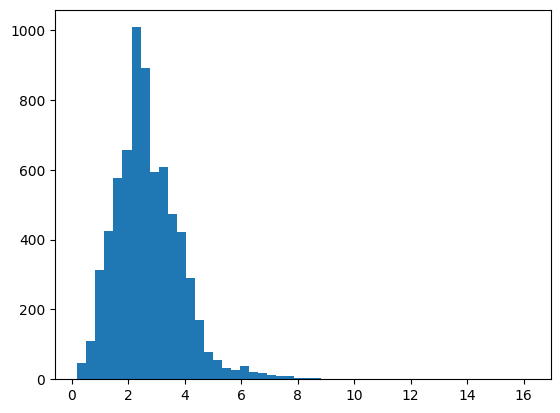

In [28]:
duration_list = []
for i in range(len(rec_annotations)):
    current = rec_annotations[i]
    duration = current['End'] - current['Start']
    duration_list.extend(duration)

duration_list = np.array(duration_list)
plt.hist(duration_list, bins = 50)
print('longest cycle:{:.2f}'.format(max(duration_list)))
print('shortest cycle:{:.2f}'.format(min(duration_list)))
print('mean cycle length:{:.2f}'.format(np.mean(duration_list)))
threshold = 10
print('Number of samples less than {:.2f} seconds:{:.2f}'.format(threshold,
                                                           np.sum(duration_list < threshold)))

print('Number of samples higher than {:.2f} seconds:{:.2f}'.format(threshold,
                                                           np.sum(duration_list > threshold)))

# Data preparation utility functions

In [27]:
#Used to split each individual sound file into separate sound clips containing one respiratory cycle each
#output: [filename, (sample_data:np.array, start:float, end:float, crackles:bool(float), wheezes:bool(float)) (...) ]

def read_wav_file(str_filename, target_rate):
    data, sample_rate = librosa.load(str_filename, sr=None)
        
    if (sample_rate != target_rate):
        data = librosa.resample(y=data, orig_sr=sample_rate, target_sr=target_rate)
    
    return (target_rate, data.astype(np.float32))

def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

def get_sound_samples(recording_annotations, file_name, root, sample_rate):
    sample_data = [file_name]
    (rate, data) = read_wav_file(os.path.join(root, file_name + '.wav'), sample_rate)
    
    for i in range(len(recording_annotations.index)):
        row = recording_annotations.loc[i]
        start = row['Start']
        end = row['End']
        crackles = row['Crackles']
        wheezes = row['Wheezes']
        audio_chunk = slice_data(start, end, data, rate)
        sample_data.append((audio_chunk, start, end, crackles, wheezes))
    return sample_data

#Fits each respiratory cycle into a fixed length audio clip, splits may be performed and zero padding is added if necessary
#original:(arr,c,w) -> output:[(arr,c,w),(arr,c,w)]
def split_and_pad(original, desiredLength, sampleRate):
    output_buffer_length = int(desiredLength * sampleRate)
    soundclip = original[0]
    n_samples = len(soundclip)
    total_length = n_samples / sampleRate #length of cycle in seconds
    n_slices = int(math.ceil(total_length / desiredLength)) #get the minimum number of slices needed
    samples_per_slice = n_samples // n_slices
    src_start = 0 #Starting index of the samples to copy from the original buffer
    output = [] #Holds the resultant slices
    for i in range(n_slices):
        src_end = min(src_start + samples_per_slice, n_samples)
        length = src_end - src_start
        copy = generate_padded_samples(soundclip[src_start:src_end], output_buffer_length)
        output.append((copy, original[1], original[2]))
        src_start += length
    return output

def generate_padded_samples(source, output_length):
    copy = np.zeros(output_length, dtype = np.float32)
    src_length = len(source)
    frac = src_length / output_length
    if(frac < 0.5):
        #tile forward sounds to fill empty space
        cursor = 0
        while(cursor + src_length) < output_length:
            copy[cursor:(cursor + src_length)] = source[:]
            cursor += src_length
    else:
        copy[:src_length] = source[:]
    #
    return copy

# filter funtions, we user bandpass' butterworth filter  
def bandpass_filter(signal, lowcut=100, highcut=2000, fs=None, order=5):
    sos = butter(order, [lowcut, highcut], btype='bp', output='sos', fs=fs)
    signal_filtered = sosfilt(sos, signal)
    return signal_filtered

In [28]:
#Takes a list of respiratory cycles, and splits and pads each cycle into fixed length buffers (determined by desiredLength(seconds))
#Then takes the split and padded sample and transforms it into a mel spectrogram

def apply_split_and_pad(original, desiredLength, sampleRate):
    output = []
    for d in original:
        
        lst_result = split_and_pad(d, desiredLength, sampleRate) #Time domain
        output.extend(lst_result)
        
    return output

# Utility used to import all samples

In [29]:
def extract_all_samples(filenames, annotation_dict, root, target_rate, desired_length):
    cycle_list = []
    for file in filenames:
        data = get_sound_samples(annotation_dict[file], file, root, target_rate)
        cycles_with_labels = [(d[0], d[3], d[4]) for d in data[1:]]
        cycle_list.extend(cycles_with_labels)
    
    #Sort into respective classes
    no_labels = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 0))]
    c_only = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 0))] 
    w_only = [c for c in cycle_list if ((c[1] == 0) & (c[2] == 1))]
    c_w = [c for c in cycle_list if ((c[1] == 1) & (c[2] == 1))]
    
    #Split up cycles into sound clips with fixed lengths so they can be fed into a CNN
    
    none  = (apply_split_and_pad(no_labels, desired_length, target_rate))
    
    c = (apply_split_and_pad(c_only, desired_length, target_rate))
    
    w = (apply_split_and_pad(w_only, desired_length, target_rate))
    
    c_w = (apply_split_and_pad(c_w, desired_length, target_rate)) 
    
    dict = {'none':none,'crackles':c,'wheezes':w, 'both':c_w}

    return dict

# Function return number of samples 
def print_sample_count(src_dict):
    print('none:{}\ncrackles:{}\nwheezes:{}\nboth:{}'.format(len(src_dict['none']),
                                                        len(src_dict['crackles']),
                                                        len(src_dict['wheezes']),
                                                        len(src_dict['both'])))
    

# Extracting Samples per set 

In [30]:
# Parameters
target_sample_rate = 32000
sample_length_seconds = 10

In [46]:
# train 
sample_dict_train = extract_all_samples(train_df.filename.tolist(), rec_annotations_dict, root, target_sample_rate, sample_length_seconds) 

In [38]:
# test
sample_dict_test = extract_all_samples(test_df.filename.tolist(), rec_annotations_dict, root, target_sample_rate, sample_length_seconds) 

In [31]:
# validation
sample_dict_val = extract_all_samples(val_df.filename.tolist(), rec_annotations_dict, root, target_sample_rate, sample_length_seconds) 

In [163]:
print('Samples Available')
print('[Training set]')
print_sample_count(sample_dict_train)

Samples Available
[Training set]
none:1850
crackles:1058
wheezes:443
both:318


In [164]:
print('Samples Available')
print('[Testing set]')
print_sample_count(sample_dict_test)

Samples Available
[Testing set]
none:1579
crackles:649
wheezes:385
both:143


In [32]:
print('Samples Available')
print('[Validation set]')
print_sample_count(sample_dict_val)

Samples Available
[Validation set]
none:215
crackles:157
wheezes:58
both:45


## Saving wav files

### Saving Train samples

In [51]:
train_dir = 'ICBHI/Train'
os.makedirs(train_dir, exist_ok=True)
train_list = []

for sample in ['none', 'crackles', 'wheezes', 'both']:
    # Saving Normal Samples
    for i, file in enumerate(sample_dict_train[sample]):
        name = sample+"_"+str(i)+".wav"
        x = file[0]
        # filtering 
        x_filt = bandpass_filter(x, fs=target_sample_rate)
        # Saving
        path = os.path.join(train_dir, name)
        sf.write(path, x_filt, target_sample_rate)
        # Creating dictionary for filename and label
        if sample=='none':
            train_dict = {'filename':name, 'id':0}
        elif sample=='crackles':
            train_dict = {'filename':name, 'id':1}
        elif sample=='wheezes':
            train_dict = {'filename':name, 'id':2}
        else:
            train_dict = {'filename':name, 'id':3}
            
        train_list.append(train_dict)

In [52]:
# Creating dataframe for train samples and save It
train_samples = pd.DataFrame(train_list, columns = train_dict.keys())
train_samples.to_csv(train_dir+'.csv', index=False)

### Saving Test samples

In [41]:
# Saving Test samples
test_dir = 'ICBHI/Test'
os.makedirs(test_dir, exist_ok=True)
test_list = []

for sample in ['none', 'crackles', 'wheezes', 'both']:
    for i, file in enumerate(sample_dict_test[sample]):
        name = sample+"_"+str(i)+".wav"
        x = file[0]
        # filtering 
        x_filt = bandpass_filter(x, fs=target_sample_rate)
        # Saving
        path = os.path.join(test_dir, name)
        sf.write(path, x_filt, target_sample_rate)
        # Creating dictionary for filename and label
        if sample=='none':
            test_dict = {'filename':name, 'id':0}
        elif sample=='crackles':
            test_dict = {'filename':name, 'id':1}
        elif sample=='wheezes':
            test_dict = {'filename':name, 'id':1}
        else:
            test_dict = {'filename':name, 'id':1}
        
        test_list.append(test_dict)

In [42]:
# Creating dataframe for Test samples and save It 
test_samples = pd.DataFrame(test_list, columns = test_dict.keys())
test_samples.to_csv(test_dir+'.csv', index=False)

### Saving Validation samples

In [37]:
# Saving Validation samples
val_dir = 'ICBHI/Val'
os.makedirs(val_dir, exist_ok=True)
val_list = []

# Saving Normal Samples
for sample in ['none', 'crackles', 'wheezes', 'both']:
    for i, file in enumerate(sample_dict_val[sample]):
        name = sample+"_"+str(i)+".wav"
        x = file[0]
        # filtering 
        x_filt = bandpass_filter(x, fs=target_sample_rate)
        # Saving
        path = os.path.join(val_dir, name)
        sf.write(path, x_filt, target_sample_rate)
        # Creating dictionary for filename and label
        if sample=='none':
            val_dict = {'filename':name, 'id':0}
        elif sample=='crackles':
            val_dict = {'filename':name, 'id':1}
        elif sample=='wheezes':
            val_dict = {'filename':name, 'id':1}
        else:
            val_dict = {'filename':name, 'id':1}
        
        val_list.append(val_dict)

In [36]:
# Creating dataframe for validation samples nd save It 
val_samples = pd.DataFrame(val_list, columns = val_dict.keys())
val_samples.to_csv(val_dir+'.csv', index=False)

In [ ]:
# Removing files
os.remove('ICBHI_final_database')